# imports

In [1]:
import pandas as pd
import numpy as np
#import os
from transformers import BertTokenizer

/home/tsl/.pyenv/versions/3.10.6/envs/plt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-03-08 14:38:25.999971: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 14:38:26.653203: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-08 14:38:26.766873: W tensorflow/stream_executor/platform/default/dso_l

In [2]:
#check local virtual env (expected 'plt')
!pyenv local

plt


# load datasets

## load functions

In [4]:
def load_data(file_path: str, size:int =-1, y_index:int=-1) -> (pd.DataFrame, pd.DataFrame) :
    """
    'file_path' = the path to the required file (typically 'train.csv' or 'test.csv' under a 'raw_data' folder)
    NB: it can be an absolute or a relative path !
    if 'size'=-1 the entire data is returned, else only the 1st 'size' rows (might also suffle if this is better) are returned
    'y_index' expected values = [-1,0,1,2,3,4,5] indicated which evaluation(s) will be returned
    outputs= (X_raw,y):
        X_raw= 2-column DataFrame ['text_id','full_text']  
        y= a 6-column DataFrame (or a 1-column DataFrame if y_index is used)
        nb of rows in X_raw and y is controlled by the 'size' kwarg
    """
    df=pd.read_csv(file_path)
    X_raw=df[['text_id','full_text']].iloc[0:size,:]
    y=df[['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']].iloc[0:size,:]
    if y_index >0 and y_index < len(y.columns):
        y=y.iloc[:,[y_index]]         
    
    return X_raw,y

In [5]:
def load_train_val_data(file_path:str, y_index:int=-1, split_ratio:float=0.3,reshuffle:bool=True) -> (pd.DataFrame, pd.DataFrame,pd.DataFrame, pd.DataFrame) :
    """
    'file_path' = the path to the required file (typically 'train.csv' or 'test.csv' under a 'raw_data' folder)
    NB: it can be an absolute or a relative path !
    'y_index' expected values = [-1,0,1,2,3,4,5] indicated which evaluation(s) will be returned
    'split_ratio'is expected to be >0 and <1 ([0.01-0.99])
    data is reshuffled when 'reshuffle'= True!
    outputs= (X_train_raw,y_train,X_val_raw,y_val):
        X_train_raw, X_test_raw= 2x 2-column DataFrames ['text_id','full_text']  
        y_train, y_test= 2x 6-column DataFrames (or  1-column DataFrames if y_index is used)
        nb of rows in (X_train_raw,y_train,X_val_raw,y_val) is controlled by the 'split_ratio' kwarg
    """
    df=pd.read_csv(file_path)
    if reshuffle:
        df=df.sample(frac=1)
    len_train=int(df.shape[0]*(1-split_ratio))
    X_train_raw=df[['text_id','full_text']].iloc[:len_train,:]
    y_train=df[['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']].iloc[:len_train,:]
    X_val_raw=df[['text_id','full_text']].iloc[len_train:,:]
    y_val=df[['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']].iloc[len_train:,:]    
    if y_index >0 and y_index < len(y_train.columns):
        y_train=y_train.iloc[:,[y_index]]         
        y_val=y_val.iloc[:,[y_index]]         
    return X_train_raw,X_val_raw,y_train,y_val

## load

In [6]:
train_path="../raw_data/train.csv"

In [7]:
X_raw, y= load_data(train_path)
X_raw.shape, y.shape

((3910, 2), (3910, 6))

In [8]:
X_train_raw,X_val_raw,y_train,y_val=load_train_val_data(train_path, split_ratio=0.3,reshuffle=False)
X_train_raw.shape,X_val_raw.shape,y_train.shape,y_val.shape

((2737, 2), (1174, 2), (2737, 6), (1174, 6))

## basic data analysis /unit testing

In [ ]:
X_raw

In [ ]:
X_raw['len_text']=X_raw.full_text.apply(len)
print(len(X_raw.full_text[0]))
X_raw

In [ ]:
X_raw.len_text.hist(bins=100)

In [ ]:
X_raw.len_text.min(),X_raw.len_text.max()

In [ ]:
x0=X_raw.full_text[0]
print(len(x0))
x0

In [ ]:
x0_split=x0.split()
print(len(x0_split))
x0_split

In [ ]:
x1=x0.replace(".", " . ")
x2=x1.replace("\n\n", " CR ")
print(len(x2.split()))
x2.split()


## functionize data pre_processing

In [9]:
def simple_text_transform(X:pd.DataFrame)->pd.DataFrame:
    """
    assumption X has a column labelled 'full_text'
    modify 'full_text': 
        *replace '\n\n' by 'CR'(=Carriage Return)
        *add spaces around dot ('.') punctation mark so that it is counted
    add a new column ('character_count')
    add a new column ('word_count')
    add a new column ('element_count')
    """
    def punctuation_processing(x:str)->str:
        x=x.replace(".", " . ")
        x=x.replace("\n\n", " CR ")
        return x
    X1=pd.DataFrame.copy(X)
    
    X1['character_count']=X1.full_text.apply(len)
    X1['word_count']=X1.full_text.apply(lambda x: len(x.split()))
    X1.full_text=X1.full_text.apply(punctuation_processing)
    X1['element_count']=X1.full_text.apply(lambda x: len(x.split()))
    return X1

In [10]:
X_raw, y= load_data(train_path)
X_raw.shape, y.shape

((3910, 2), (3910, 6))

In [11]:
X_raw1=simple_text_transform(X_raw)
print(X_raw1.shape)
X_raw1

(3910, 5)


,text_id,full_text,character_count,word_count,element_count
0,0016926B079C,I think that students would benefit from learn...,1387,261,282
1,0022683E9EA5,When a problem is a change you have to let it ...,2635,533,552
2,00299B378633,"Dear, Principal CR If u change the school poli...",1663,320,340
3,003885A45F42,The best time in life is when you become yours...,3973,728,773
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,1326,234,239
...,...,...,...,...,...
3905,FFCDB2524616,"I agree with Ralph Waldo Emerson's "" CR To be ...",1415,263,278
3906,FFD29828A873,I believe using cellphones in class for educat...,977,179,187
3907,FFD9A83B0849,"Working alone, students do not have to argue w...",2603,465,487
3908,FFDC4011AC9C,"""A problem is a chance for you to do your best...",1298,257,264


In [12]:
print('character range : ',X_raw1.character_count.min(),X_raw1.character_count.max())
print('word range : ',X_raw1.word_count.min(),X_raw1.word_count.max())
print('element range : ',X_raw1.element_count.min(),X_raw1.element_count.max())

character range :  82 6044
word range :  14 1260
element range :  14 1302


array([[<Axes: title={'center': 'character_count'}>,
        <Axes: title={'center': 'word_count'}>],
       [<Axes: title={'center': 'element_count'}>, <Axes: >]],
      dtype=object)

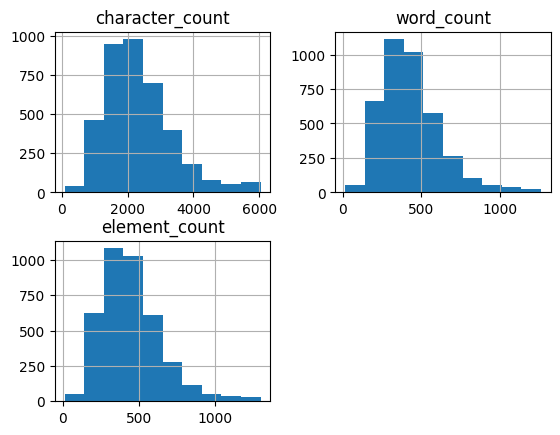

In [13]:
X_raw1.hist()

# Baseline (simple mean)

## baseline in one cell

In [ ]:
X_train_raw, y_train= load_data(train_path)
baseline_score=np.sqrt(((y_train-y_train.mean())**2).mean(axis=0)).mean()
baseline_score

# BERT Basic Model

## Tokenize inputs

### load tokenizer

In [14]:
from transformers import BertTokenizer

In [15]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

### unit test tokenizer

In [ ]:
X_raw

In [ ]:
x0_tokenized=tokenizer(X_raw.full_text[0])
x0_tokenized

In [ ]:
print(len(x0_tokenized['input_ids']))

In [ ]:
print(tokenizer.decode(x0_tokenized['input_ids']))

### tokenize clean sheet

In [81]:
X_tokenized=tokenizer(list(X_raw.full_text), padding='max_length',truncation=True,return_tensors="tf",return_token_type_ids=False)

In [82]:
X_tokenized.keys(), X_tokenized['input_ids'].shape

(dict_keys(['input_ids', 'attention_mask']), TensorShape([3910, 512]))

In [83]:
X_tokenized

{'input_ids': <tf.Tensor: shape=(3910, 512), dtype=int32, numpy=
array([[  101,   146,  1341, ...,     0,     0,     0],
       [  101,  1332,   170, ...,  1106,  1838,   102],
       [  101, 12956,   117, ...,     0,     0,     0],
       ...,
       [  101,  9612,  2041, ...,  2148,  1111,   102],
       [  101,   107,   138, ...,     0,     0,     0],
       [  101,  2408,  1234, ...,  1112,  1128,   102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(3910, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>}

In [84]:
X_tokenized['input_ids'][0]

<tf.Tensor: shape=(512,), dtype=int32, numpy=
array([  101,   146,  1341,  1115,  1651,  1156,  5257,  1121,  3776,
        1120,  1313,   117,  1272,  1152,  1281,  1204,  1138,  1106,
        1849,  1105,  1243,  1146,  1346,  1107,  1103,  2106,  1106,
        5946,  1105,  1202,  1175,  1716,   119,  1781,  1178,  3553,
        6618,  1172,  1272,  1120,  1175,  1402,  1152,   112,  1325,
        1129,  2653,  1167,  2209,   119,  1152,  1209,  1129,  6062,
        1120,  1313,   119,  1109, 20773,  1226,  1104,  1278,  1110,
        2033,  2407,   119,  1128,  5314,  1146,  1301,  8415,  1240,
        3307,  1105,  1301,  1106,  1240,  9369,  1105,  1440,  1120,
        1240,  8217,  1116,   119,  1170,  1128,  1341,  1128,  3015,
         170, 11378,   190,  1301,  1440,  1107,  1103,  5220,  1105,
        1128,  2339,  1719,  1136,  1176,  1122,  1137,  1128,  1440,
        1105,  1267,   170, 24754,   119,  1599,  1128,   112,  1325,
        1138,  1106,  1849,   119,  1114,  1

## Built model

### model dirty gardenning

In [16]:
X_raw

,text_id,full_text
0,0016926B079C,I think that students would benefit from learn...
1,0022683E9EA5,When a problem is a change you have to let it ...
2,00299B378633,"Dear, Principal\n\nIf u change the school poli..."
3,003885A45F42,The best time in life is when you become yours...
4,0049B1DF5CCC,Small act of kindness can impact in other peop...
...,...,...
3905,FFCDB2524616,"I agree with Ralph Waldo Emerson's ""\n\nTo be ..."
3906,FFD29828A873,I believe using cellphones in class for educat...
3907,FFD9A83B0849,"Working alone, students do not have to argue w..."
3908,FFDC4011AC9C,"""A problem is a chance for you to do your best..."


In [79]:
from transformers import TFBertModel

In [80]:
# Load pretrained model/tokenizer
model = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [32]:
X_tokenized['input_ids'][0]

<tf.Tensor: shape=(512,), dtype=int32, numpy=
array([  101,   146,  1341,  1115,  1651,  1156,  5257,  1121,  3776,
        1120,  1313,   117,  1272,  1152,  1281,  1204,  1138,  1106,
        1849,  1105,  1243,  1146,  1346,  1107,  1103,  2106,  1106,
        5946,  1105,  1202,  1175,  1716,   119,  1781,  1178,  3553,
        6618,  1172,  1272,  1120,  1175,  1402,  1152,   112,  1325,
        1129,  2653,  1167,  2209,   119,  1152,  1209,  1129,  6062,
        1120,  1313,   119,  1109, 20773,  1226,  1104,  1278,  1110,
        2033,  2407,   119,  1128,  5314,  1146,  1301,  8415,  1240,
        3307,  1105,  1301,  1106,  1240,  9369,  1105,  1440,  1120,
        1240,  8217,  1116,   119,  1170,  1128,  1341,  1128,  3015,
         170, 11378,   190,  1301,  1440,  1107,  1103,  5220,  1105,
        1128,  2339,  1719,  1136,  1176,  1122,  1137,  1128,  1440,
        1105,  1267,   170, 24754,   119,  1599,  1128,   112,  1325,
        1138,  1106,  1849,   119,  1114,  1

In [23]:
model.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [58]:
from tensorflow.keras import layers,Model

In [50]:
token_ids =layers.Input(shape=(512,),dtype=np.int32,name='input_ids')
attention_mask = layers.Input(shape=(512,),dtype=np.int32,name='attention_mask')
backbone = TFBertModel.from_pretrained('bert-base-cased')
backbone.trainable = False

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [51]:
output= backbone(dict(input_ids=token_ids,attention_mask=attention_mask))

In [52]:
output.__dict__

{'last_hidden_state': <KerasTensor: shape=(None, 512, 768) dtype=float32 (created by layer 'tf_bert_model_3')>,
 'pooler_output': <KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'tf_bert_model_3')>,
 'past_key_values': None,
 'hidden_states': None,
 'attentions': None,
 'cross_attentions': None}

In [53]:
x = layers.Dense(128,activation='relu')(output[1])

In [54]:
output = layers.Dense(6,activation='linear')(x)

In [55]:
model = Model(inputs=dict(input_ids=token_ids,attention_mask=attention_mask),outputs=output)

In [57]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model_3 (TFBertModel)  TFBaseModelOutputWi  108310272   ['attention_mask[0][0]',         
                                thPoolingAndCrossAt               'input_ids[0][0]']              
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [60]:
utils.plot_model(model,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [63]:
#parallele layers : 1 layer for each output (score)
cohesion_output=layers.Dense(1, activation="linear", name="cohesion")(x)
syntax_output=layers.Dense(1, activation="linear", name="syntax")(x)
vocabulary_output=layers.Dense(1, activation="linear", name="vocabulary")(x)
phraseology_output=layers.Dense(1, activation="linear", name="phraseology")(x)
grammar_output=layers.Dense(1, activation="linear", name="grammar")(x)
conventions_output=layers.Dense(1, activation="linear", name="conventions")(x)

# Assembling the model
model2 = Model(inputs=dict(input_ids=token_ids,attention_mask=attention_mask), outputs=[cohesion_output, syntax_output, vocabulary_output, phraseology_output, grammar_output, conventions_output])

In [64]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model_3 (TFBertModel)  TFBaseModelOutputWi  108310272   ['attention_mask[0][0]',         
                                thPoolingAndCrossAt               'input_ids[0][0]']              
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                         

### Model clean sheet

In [70]:
from transformers import TFBertModel
from tensorflow.keras import layers,Model

In [71]:
# Load pretrained model/tokenizer
bert = TFBertModel.from_pretrained('bert-base-cased')
bert.trainable=False

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [72]:
token_ids_layer =layers.Input(shape=(512,),dtype=np.int32,name='input_ids')
attention_mask_layer = layers.Input(shape=(512,),dtype=np.int32,name='attention_mask')

In [73]:
input_layer=dict(input_ids=token_ids_layer,attention_mask=attention_mask_layer)

In [74]:
pooler_output_layer= bert(input_layer)[1]

In [75]:
dense1_layer = layers.Dense(128,activation='relu')(pooler_output_layer)

In [76]:
#parallel layers : 1 layer for each output (score)
cohesion_output=layers.Dense(1, activation="linear", name="cohesion")(dense1_layer)
syntax_output=layers.Dense(1, activation="linear", name="syntax")(dense1_layer)
vocabulary_output=layers.Dense(1, activation="linear", name="vocabulary")(dense1_layer)
phraseology_output=layers.Dense(1, activation="linear", name="phraseology")(dense1_layer)
grammar_output=layers.Dense(1, activation="linear", name="grammar")(dense1_layer)
conventions_output=layers.Dense(1, activation="linear", name="conventions")(dense1_layer)

In [77]:
# Assembling the model
model = Model(inputs=input_layer, 
               outputs=[cohesion_output, syntax_output, vocabulary_output, phraseology_output, grammar_output, conventions_output])

In [78]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model_6 (TFBertModel)  TFBaseModelOutputWi  108310272   ['attention_mask[0][0]',         
                                thPoolingAndCrossAt               'input_ids[0][0]']              
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                         

###  Definy initate_bert_model() function

In [89]:
def initiate_bert_model():
    bert = TFBertModel.from_pretrained('bert-base-cased')
    bert.trainable=False
    
    token_ids_layer =layers.Input(shape=(512,),dtype=np.int32,name='input_ids')
    attention_mask_layer = layers.Input(shape=(512,),dtype=np.int32,name='attention_mask')
    input_layer=dict(input_ids=token_ids_layer,attention_mask=attention_mask_layer)
    
    pooler_output_layer= bert(input_layer)[1]
    
    dense1_layer = layers.Dense(128,activation='relu')(pooler_output_layer)
    
    #parallel layers : 1 layer for each output (score)
    cohesion_output=layers.Dense(1, activation="linear", name="cohesion")(dense1_layer)
    syntax_output=layers.Dense(1, activation="linear", name="syntax")(dense1_layer)
    vocabulary_output=layers.Dense(1, activation="linear", name="vocabulary")(dense1_layer)
    phraseology_output=layers.Dense(1, activation="linear", name="phraseology")(dense1_layer)
    grammar_output=layers.Dense(1, activation="linear", name="grammar")(dense1_layer)
    conventions_output=layers.Dense(1, activation="linear", name="conventions")(dense1_layer)
    
    # Assembling the model
    model = Model(inputs=input_layer, 
            outputs=[cohesion_output, syntax_output, vocabulary_output, phraseology_output, grammar_output, conventions_output])
    return model

###  Instanciate Model (with initate_bert_model() function !)

In [90]:
model=initiate_bert_model()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [91]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model_9 (TFBertModel)  TFBaseModelOutputWi  108310272   ['attention_mask[0][0]',         
                                thPoolingAndCrossAt               'input_ids[0][0]']              
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                         

## compile model

In [95]:
from keras import backend as K

In [96]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [93]:
model.compile(loss='mse', optimizer='adam', loss_weights=[1/6 for i in range(6)], metrics=root_mean_squared_error)

## Train model

In [94]:
from tensorflow.keras import callbacks

In [97]:
es = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [107]:
type(X_tokenized.data),X_tokenized.data.keys(),X_tokenized['input_ids'].shape

(dict, dict_keys(['input_ids', 'attention_mask']), TensorShape([3910, 512]))

In [ ]:
history=model.fit(X_tokenized.data,
          y,
          validation_split=0.2,
          batch_size=64,
          epochs=100,
          verbose=1,
          callbacks=[es])

Epoch 1/100
49/49 [==============================] - ETA: 0s - loss: 1.0604 - cohesion_loss: 0.8883 - syntax_loss: 0.8496 - vocabulary_loss: 1.5251 - phraseology_loss: 1.1059 - grammar_loss: 1.3673 - conventions_loss: 0.6261 - cohesion_root_mean_squared_error: 0.7783 - syntax_root_mean_squared_error: 0.7629 - vocabulary_root_mean_squared_error: 0.8975 - phraseology_root_mean_squared_error: 0.8476 - grammar_root_mean_squared_error: 0.9066 - conventions_root_mean_squared_error: 0.6760 

## Evaluate Model